# Project part A

## Downloading the data

In [19]:
import urllib.request
import urllib.parse
import json
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_category_pages(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "list=categorymembers"
    dataformat ="format=json&cmlimit=1000"
    safe_title = "cmtitle=" + urllib.parse.quote_plus(title)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    categories_list = wikitext_json["query"]["categorymembers"]

    return categories_list

def get_wiki_data(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    safe_title = "titles=" + urllib.parse.quote_plus(title)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    pages_content_list = wikitext_json["query"]["pages"]

    return pages_content_list

def get_wiki_pages_with_prefix(prefix, namespace_id):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "list=allpages"
    dataformat ="format=json&aplimit=500"
    apprefix = "apprefix=" + urllib.parse.quote_plus(prefix)
    apnamespace = "apnamespace=" + str(namespace_id)

    query = "{}{}&{}&{}&{}&{}".format(baseurl, action, content, apprefix, apnamespace, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    title_list_raw = wikitext_json["query"]["allpages"]

    if len(title_list_raw) > 0:
        title_list = [entry["title"] for entry in title_list_raw]
    else:
        title_list = []

    return title_list

def parse_page(page, pages_list, graph):

    # Does page exist?
    if "revisions" in page:
        content = page["revisions"][0]["slots"]["main"]["*"]  # * from rvslots
        title = page["title"]

        # Normalize whitespace
        content = re.sub(r'[\n\t\ ]+', ' ', content)

        # Retreive links to User: pages
        links = re.findall('\[(User:[^/\]\[\|]+)[\]\|]', content) # Previous: '\[([^\]\[\|:]+)[\]\|]'
        filtered_links = np.unique(links)

        # Heuristic for Archive pages
        #archive_number = re.findall('\|\s*counter\s*=\s*([^\|\}\s]+)', content)

        origin_title_list = re.findall('([^/]+).*', title)
        if len(origin_title_list) > 0:
            origin_title = origin_title_list[0]
        else:
            origin_title = title

        # Add User: links to graph
        count = 0
        for link in filtered_links:
            if link not in pages_list:
                graph.add_node(link, page_class="user")
            graph.add_edge(link, origin_title)
            count += 1
        
        # Article word count
        #word_count = len(re.findall('\w+', content.lower()))
        #graph.nodes(data=True)[title]["word_count"] = word_count

        return count
    else:
        return 0

def scrape_wiki(category_title):
    # Params
    wiki_api_page_request_limit = 50
    namespace_id_talk = 1

    # Get pages in category
    pages = get_category_pages(category_title)
    titles = [r["title"] for r in pages]

    # Filter only Talk pages
    filtered_titles = [title for title in titles if "Talk:" in title] # Todo might be worth using regex here

    # Graph
    page_graph = nx.DiGraph()
    for page in filtered_titles:
        page_graph.add_node(page, page_class="talk")

    # Find archive pages
    archive_titles = []
    for title in filtered_titles:
        curr_archive_titles = get_wiki_pages_with_prefix(title.replace("Talk:", "") + "/Archive", namespace_id_talk)
        archive_titles += curr_archive_titles
        print(title + ": " + str(len(curr_archive_titles)))

    all_titles = filtered_titles + archive_titles

    # Split list because of API limits
    split_titles_list = list(chunks(all_titles, wiki_api_page_request_limit))

    results = []
    for sublist in split_titles_list:
        titlestr = "|".join(sublist)
        pages_contents = get_wiki_data(titlestr)
        curr_results = [parse_page(page_content, all_titles, page_graph) for key, page_content in pages_contents.items()]
        results += curr_results
        print(curr_results)

    print(results)

    return page_graph

page_graph = scrape_wiki("Category:Wikipedia_level-2_vital_articles")

Talk:Africa: 7
Talk:Agriculture: 4
Talk:Ancient history: 1
Talk:Animal: 6
Talk:Architecture: 3
Talk:Arithmetic: 1
Talk:Asia: 4
Talk:Astronomy: 2
Talk:Atom: 7
Talk:Biology: 3
Talk:Book: 2
Talk:Business: 7
Talk:Cell (biology): 2
Talk:Chemical element: 3
Talk:Chemistry: 4
Talk:City: 2
Talk:Civilization: 7
Talk:Climate: 2
Talk:Clothing: 2
Talk:Communication: 2
Talk:Computer: 6
Talk:Country: 7
Talk:Culture: 6
Talk:Death: 6
Talk:Deity: 2
Talk:Disease: 1
Talk:Early modern period: 0
Talk:Ecology: 3
Talk:Economics: 9
Talk:Education: 7
Talk:Electricity: 3
Talk:Emotion: 3
Talk:Energy: 7
Talk:Engineering: 3
Talk:Entertainment: 1
Talk:Ethics: 4
Talk:Ethnicity: 3
Talk:Europe: 15
Talk:Evolution: 78
Talk:Family: 2
Talk:Fire: 2
Talk:Folklore: 1
Talk:Food: 3
Talk:Geography: 2
Talk:Geology: 2
Talk:Geometry: 2
Talk:Government: 3
Talk:History: 16
Talk:History of science: 11
Talk:Home: 1
Talk:Human sexuality: 3
Talk:Knowledge: 2
Talk:Land: 1
Talk:Language: 5
Talk:Late modern period: 0
Talk:Law: 5
Talk:Liter

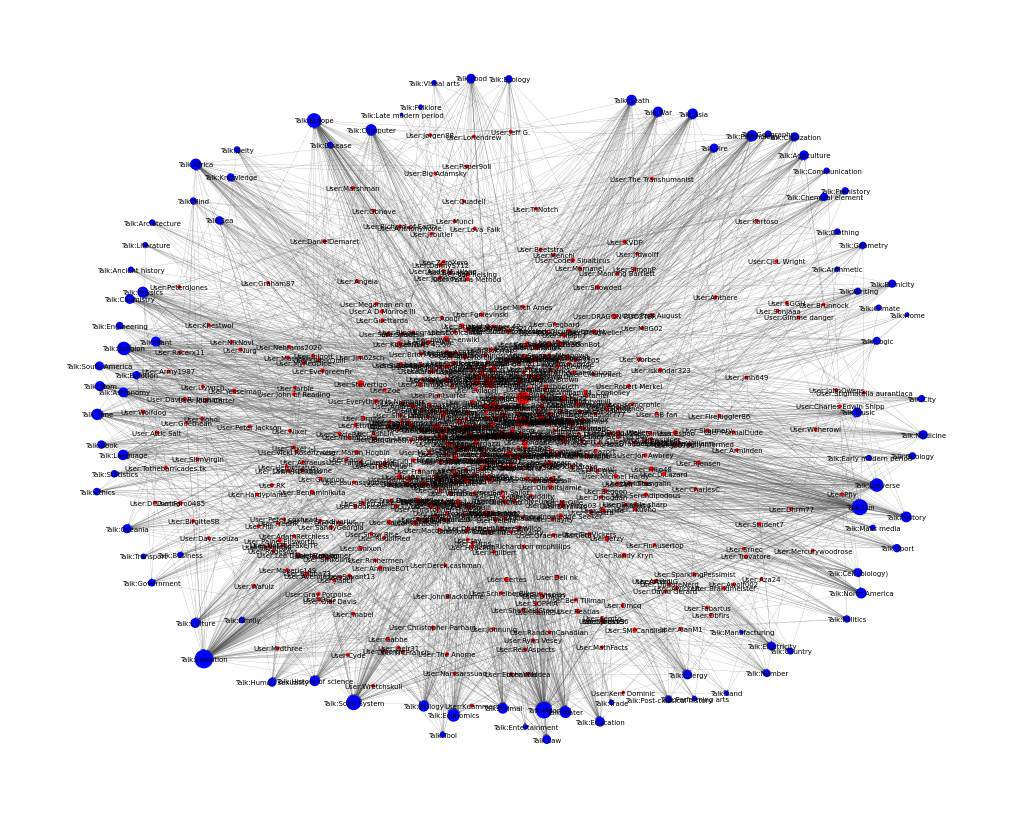

In [20]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

graph = page_graph.copy()

# Only keep users with a high degree
for node in page_graph.nodes(data=True):
    if node[1]["page_class"] == "user":
        if page_graph.out_degree(node[0]) <= 2:
            graph.remove_node(node[0])

# Remove outliers
cc = nx.weakly_connected_components(graph)
largest_c = max(cc, key=lambda x: len(x))
rsubgraph = nx.subgraph(graph, largest_c)

# Positions (currently unused)
pos = nx.nx_agraph.graphviz_layout(rsubgraph, prog="neato")

# Color and size according to coast and degree
color_talk = "#0000FF"
color_user = "#FF0000"
node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in rsubgraph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in rsubgraph.nodes]

nx.draw(rsubgraph, with_labels=True, font_weight='light', font_size=5, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

## Preliminary data analysis metrics

> An explanation of the central idea behind your final project (What is the idea? Why is it interesting? Which datasets did you need to explore the idea? How did you download them?)

A walk-through of your preliminary data analysis, addressing:
> - What is the total size of your data? (MB, number of pages, other variables, etc.)
> - What is the network you will be analyzing? (number of nodes? number of links?, degree distributions, what are node attributes?, etc.)
> - What is the text you will be analyzing?
> - How will you tie networks and text together in your paper?